# Bayesian Problem:

Afrikada safari turuna çıktığınızı ve orada sadece aslanların,kaplanların ve ayıların yaşadığını varsayın.
Ama hangisinden kaç tane olduğunu toplamda bilmiyoruz.
Yaptığımız turda 3 aslan,2 kaplan ve 1 ayı gördüğünüzü düşünün.
Örneklem uzayımızda her hayvanın görülme şansının eşit şansa sahip olduğunu varsaydığımızda,
Her hayvandan kaç tane olduğunu ve tura tekrar çıktığımızda ilk göreceğimiz hayvanın ayı olacağını olasılıksal olarak
hesaplayalım.

# Bayesçi Yaklaşım:

Frekansçı bakış açısıyla bu olasılık problemini ele alsaydık,sadece gözlenen hayvan sayısını kullanıp,totalde kaç 
hayvan yaşadığının olasılığını bulmaya çalışacaktık.Yani datanın kendisi konuşacaktı.
Ancak Bayesçi yaklaşımda,prior olasılık ve dağılımlar söz konusu,ki burada prior'a karşılık 
problemimizde tüm türlerin eşit sansa sahip olduğu bilgisi söylendi.

Sonsuz sayıda gözlemlerde prior effekti kaybolur ve sadece datayı kullanırız.
Ancak problemimizde olduğu gibi sınırlı sayıda gözlemle çalıştığımızda prior etkisi çok fazla olur ve aynı zamanda belirsizlikte
büyük olur.
Prior'ların ağırlıklarını kendi güven aralıklarımıza göre ağırlıklandırabiliriz.Bunu bir yöntem olarak deneyelim.

# Model

Modelimizde şu sistemi takip edelim:
    
1-)Modelimiz pk parametresine sahip multinomial distribution'a sahip.

2-)pk parametresinin Prior dağılımı Dirichet Distribution'dır

3-)$\alpha$ vektör prior Dirichlet Dağılımının bir parametresidir,dolayısıyla bir hiperparametredir.

Dirichlet Prior'una sahip Multinomial Dağılıma Dirichlet-Multinomial Dağılım denir.

Modelimizde şu eşitlikleri kullanacağız:
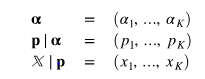

Amacımız verilen c=[aslan_sayısı,kaplan_sayısı,ayı_sayısı] gözlem vektöründen
P(Aslan),P(Kaplan),P(Ayı) olasılıklarını bulmaktır.

# Multinomial Dağılım

Ele aldığımız problem n tane bağımsız deneme ve k tane çıktıdan oluşan klasik bir multinomial dağılım örneğidir.
Vahşi hayat gözlemlerimize bakarsak burada n=6 ve k=3'tür.
Her olasılık çıktısı pk parameterisiyle karakterize edilmiştir ve toplamı 1 olmalıdır.
Daha önce belirttiğimiz gibi amacımız P(Aslan),P(Kaplan),P(Ayı) olasılıklarını verilen gözlemlere dayanarak bulmaktır.
Burada gözlemlerimiz Aslan_Sayısı=3,Kaplan_Sayısı=2,Ayı_Sayısı=1'dir

# Dirichlet Dağılımı

Bayesçi İstatistikte Multinomial Dağılımın prior'u Dirichlet Dağılımıdır.
Birlikte Dirichlet-Multinomial Dağılım olarak söylenir.
Dirichlet dağılımı $\alpha$ konstantrasyon hiperparametresiyle karakterize edilir.

# HiperParametreler ve Prior Düşüncelerimiz

Daha önce söylediğimiz gibi $\alpha$ vektörü prior dağılımın hiperparametresidir.
Bu vektör daha sonra hyperprior denilen kendi iç prior dağılımına da dönüşebilir.Ancak biz burada hiperprior'u değil
hiperparametreleri kullanacağız.

Hiperparametre vektörü pseudo sayıları olarak düşünülebilir.Biz burada prior "inancımızı" gösterirken bunu kullanacağız.
Eğer her türün gözlemlenme sayısının eşit olasılıklı olduğuna inanıyorsak,hiperparametremizi uniform hale dönüştürebiliriz.
O zaman alfa'mız şu şekilde olur : $\alpha$=[1,1,1].
Prior efektini bu sayıları yükselterek yada azaltarak,değiştirebiliriz.Bu prior inancımıza dair eğer yeterli güven duymadığımız
durumda faydalı olabilir.
Çalışma sırasında hiperparametreleri farklı ayarlarda yaparak etkisini gözlemlemeye çalışacağız.
Ancak genel olarak $\alpha$=[1,1,1] parametresiyle çalışacağız.

$\alpha$ vektörünü düşünmenin en iyi yolu bunun bizim bir prior inancımız olduğudur.
Eğer ilk etapta her türün aynı sayıda var olduğunu düşünüyorsak o zaman elimizdeki pseudo sayıları da eşit olmalıdır.

Basitçe Modele başlayalım

In [4]:
import os

os.chdir('C:\\Users\\TCHTOPCUOGLU\\Desktop\\yil_Tek')

In [5]:
import pandas as pd
import numpy as np

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 22
#%matplotlib inline

#from matplotlib import MatplotlibDeprecationWarning

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
#warnings.filterwarnings('ignore', category=MatplotlibDeprecationWarning)

import pymc3 as pm

# Helper functions
from utils  import draw_pdf_contours, Dirichlet, plot_points, annotate_plot, add_legend, display_probs

# Problem Özellikleri

Daha önce belirttiğimiz gibi α=[1,1,1] hiperparametresini kullanacağız.
Sonrasında bu parametreyi değiştirip modele etkisini gözlemlemeye çalışacağız.
Unutmayın ki hiperparametreleri değiştirmek prior düşüncemizi değiştirmekle eş değerdir.

In [6]:
# observations
animals = ['lions', 'tigers', 'bears']
c = np.array([3, 2, 1])

# hyperparameters (initially all equal)
alphas = np.array([1, 1, 1])

alpha_list = [np.array([0.1, 0.1, 0.1]), np.array([1, 1, 1]),
                    np.array([5, 5, 5]), np.array([15, 15, 15])]

# Expected Value

Kaynak: http://users.cecs.anu.edu.au/~ssanner/MLSS2010/Johnson1.pdf

pk parametresinin posterior'una ilişkin nokta tahmini yapmak için bir yöntem expected value kavramını kullanmaktır.
Dirichlet-Multinomial Dağılım için expected value formulü şu şekildedir : 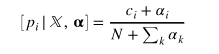

α=[1,1,1] hiperparametre ve c=[3,2,1] gözlem vektörlerini kullanaraktan ayıların bir sonra turda görülme olasılığının 
beklenen değerini P(Ayı)=2/9=%22 olarak bulabiliriz.

Az sayıda gözleme sahip olduğumuzdan bu sonucun pek de tatmin edici olduğunu söylemek zor.
Bu yüzden Bayesçi modelleme yaklaşımını takip edeceğiz.
Expected value bizim spesifik bir denememiz için en iyi keşfimizdir diyebiliriz.Hiperparametreleri değiştirerek beklenen değeri
farklılaştırmakta mümkün.

İlk etapta elimizde default α vektörüyle yaptığımız matematiği teyit edelim:

In [7]:
display_probs(dict(zip(animals, (alphas + c) / (c.sum() + alphas.sum()))))

Species: lions    Prevalence: 44.44%.
Species: tigers   Prevalence: 33.33%.
Species: bears    Prevalence: 22.22%.


İşte bunlar Expected Value'lardır

Şimdi hiperparametreleri değiştirerek(yani prior düşüncemizi) bunun beklenen değere etkisini ölçelim:

In [8]:
values = []
for alpha_new in alpha_list:
    values.append((alpha_new + c) / (c.sum() + alpha_new.sum()))

value_df = pd.DataFrame(values, columns = animals)
value_df['alphas'] = [str(x) for x in alpha_list]
value_df

,lions,tigers,bears,alphas
0,0.492063,0.333333,0.174603,[0.1 0.1 0.1]
1,0.444444,0.333333,0.222222,[1 1 1]
2,0.380952,0.333333,0.285714,[5 5 5]
3,0.352941,0.333333,0.313725,[15 15 15]


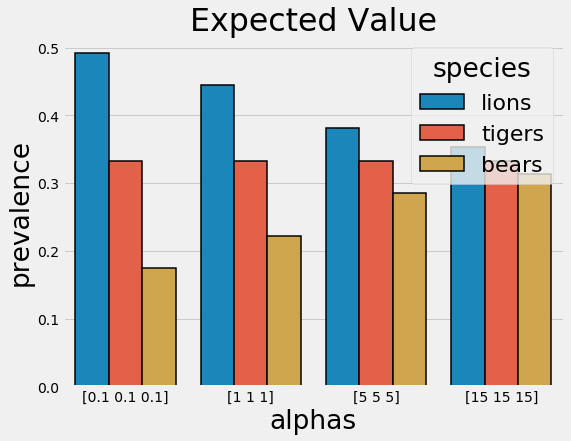

In [9]:
melted = pd.melt(value_df, id_vars = 'alphas', value_name='prevalence',
        var_name = 'species')

plt.figure(figsize = (8, 6))
sns.barplot(x = 'alphas', y = 'prevalence', hue = 'species', data = melted,
            edgecolor = 'k', linewidth = 1.5);
plt.xticks(size = 14); plt.yticks(size = 14)
plt.title('Expected Value');

Görüldüğü gibi hiperparametreyi arttırdığımızda,türlerin expected değerleri 1/3 etrafında toplanıyor.
Bu bizim için ilk etapta anlamlıdır.
Eğer pseudo sayılarını arttırırsak prior'umuzu daha sağlam bir şekilde ifade edebiliriz.
Daha çok ağırlık verilmiş prior'la data daha az sorun çıkartır.

# Maksimum Posterior Tahmini

Kaynak: http://users.cecs.anu.edu.au/~ssanner/MLSS2010/Johnson1.pdf
        
Posterior'ın maksimumu tahmin edilmek istenen başka bir durumdur ki bu durum posterior dağılıma tekabül eder.

Maksimum Posterior Formulü:

$${\displaystyle \operatorname {arg\,max} \limits _{\mathbf {p} }p(\mathbf {p} \mid \mathbb {X} )={\frac {\alpha _{i}+c_{i}-1}{\sum _{i}(\alpha _{i}+c_{i}-1)}},\qquad \forall i\;\alpha _{i}+c_{i}>1}$$

α=[1,1,1] olduğu durumda bu gözlemlerimizin frekanslarına tekabül eder.

In [10]:
display_probs(dict(zip(animals, (alphas + c - 1) / sum(alphas + c - 1))))

Species: lions    Prevalence: 50.00%.
Species: tigers   Prevalence: 33.33%.
Species: bears    Prevalence: 16.67%.


Hiperparametre seçimimize göre bu tahmin bizim için mantıklıdır.Çünkü datayı sadece Maksimum Posterior'ı bulmak açısından 
kullandık.
Hİperparametreleri değiştirelim ve etkisini gözlemleyelim:

In [11]:
values = []
for alpha_new in alpha_list:
    values.append((alpha_new + c - 1) / sum(alpha_new + c - 1))

value_df = pd.DataFrame(values, columns = animals)
value_df['alphas'] = [str(x) for x in alpha_list]
value_df

,lions,tigers,bears,alphas
0,0.636364,0.333333,0.030303,[0.1 0.1 0.1]
1,0.500000,0.333333,0.166667,[1 1 1]
2,0.388889,0.333333,0.277778,[5 5 5]
3,0.354167,0.333333,0.312500,[15 15 15]


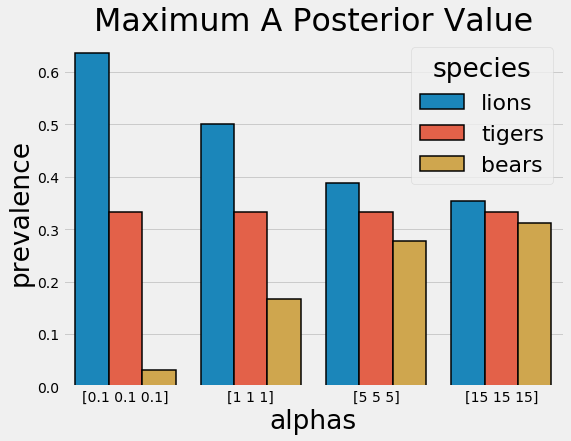

In [12]:
melted = pd.melt(value_df, id_vars = 'alphas', value_name='prevalence',
        var_name = 'species')

plt.figure(figsize = (8, 6))
sns.barplot(x = 'alphas', y = 'prevalence', hue = 'species', data = melted,
            edgecolor = 'k', linewidth = 1.5);
plt.xticks(size = 14); plt.yticks(size = 14)
plt.title('Maximum A Posterior Value');

Expected value hesaplamasında olduğu gibi aynı sonucu elde ettik.
Yani prior düşüncelerimiz değiştikçe dataya olan efektini gözlemledik.

Ayrıca hem expected value hem maksimum posterior hesaplaması belirsizlik olmamakla birlikte sadece bir nokta tahmini verir.
Az sayıda gözlemimiz olduğundan büyük oranda belirsizlik olur.
Şimdi sıra Bayesçi Modellemede:

# Bayesçi Modelleme

Şimdi sıra Bayesçi Modellemede.
Unutmayalım ki multinomial Dirichlet dağılımını prior c=[1,1,1] hiperparametreleriyle prior olarak kullanıyoruz.
Amacımız her türden ne kadar olduğunu olasılığını veren multinomial pk parametrelerini bulmak.

# PyMC3 ve MCMC

Problemin çözümünde PyMC3 framework'ünü kullanarak model yapacağız.Aynı zamanda posterior kısımdan
örnekler çekebilmek için Markov Chain-Monte Carlo yaklaşımını da kullacağız.
Yeteri kadar örnekle tahminimiz doğru posterior dağılıma yakınsayacaktır.

PyMC3 ile model kurmak basit.Her dağılım parametreleriyle beraber belirtilir.Sonrasında gözlenen sayıları "gözlenen parametre"
değerlerine atayarak multinomial Dirichlet dağılımı prior olarak kullanılır.

α=[1,1,1] parametrelerini ana modelimizde kullanacağız.

In [13]:
with pm.Model() as model:
    # Parameters of the Multinomial are from a Dirichlet
    parameters = pm.Dirichlet('parameters', a=alphas, shape=3)
    # Observed data is from a Multinomial distribution
    observed_data = pm.Multinomial(
        'observed_data', n=6, p=parameters, shape=3, observed=c)

In [14]:
model

# Sampling From Model

Aşağıdaki kod posterior içerisindeki 2 zincirden 1000 örnek çekiyor.Bunların 500 tanesini tuning için kullanacağız.
Bu şu anlama geliyor:modeldeki her random değişken için -parametreler- posterior da 2000 lik örneğe sahip olacağız.

In [15]:
with model:
    # Sample from the posterior
    trace = pm.sample(draws=1000, chains=2, tune=500, 
                      discard_tuned_samples=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [parameters]
Sampling 2 chains: 100%|███████████████████████████████████████████████████████| 3000/3000 [00:11<00:00, 263.59draws/s]


# Sonuçlara Bakalım

In [16]:
summary = pm.summary(trace)
summary.index = animals
summary

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
lions,0.450635,0.157885,0.003160,0.151590,0.741460,2181.194316,0.999508
tigers,0.331806,0.151354,0.003522,0.064003,0.615039,1838.235193,0.999874
bears,0.217559,0.131852,0.002809,0.015807,0.477387,2088.600925,1.000157


Sonuçlar expected value değerleriyle neredeyse aynı.
Ancak %95 olasılık aralığında ve yüksek standart sapma değerleri bize gösteriyorki belirsizlik range'imiz hala var.

In [17]:
# Samples
trace_df = pd.DataFrame(trace['parameters'], columns = animals)
trace_df.head()

,lions,tigers,bears
0,0.609876,0.221870,0.168254
1,0.409409,0.282420,0.308172
2,0.325763,0.417909,0.256328
3,0.684233,0.267394,0.048373
4,0.344748,0.598542,0.056710


Tek nokta tahmini için örneklemlerin ortamalasını kullabiliriz.

In [18]:
# For probabilities use samples after burn in
pvals = trace_df.iloc[:, :3].mean(axis = 0)
display_probs(dict(zip(animals, pvals)))

Species: lions    Prevalence: 45.06%.
Species: tigers   Prevalence: 33.18%.
Species: bears    Prevalence: 21.76%.


tekrar görüleceği üzere sonuçlar daha önce hesapladığımız expected value'larla aynı.
belirsizlik range'imiz de var

In [19]:
summary.iloc[:, 3:5]

,hpd_2.5,hpd_97.5
lions,0.151590,0.741460
tigers,0.064003,0.615039
bears,0.015807,0.477387


tahminimizde ki yüksek oranda belirsiziliği bu noktada yakalayabiliyoruz.Bunun bir sebebi düşük sayıda datamız olması.

# Diagnostic Grafikleri

# Posterior Grafikleri

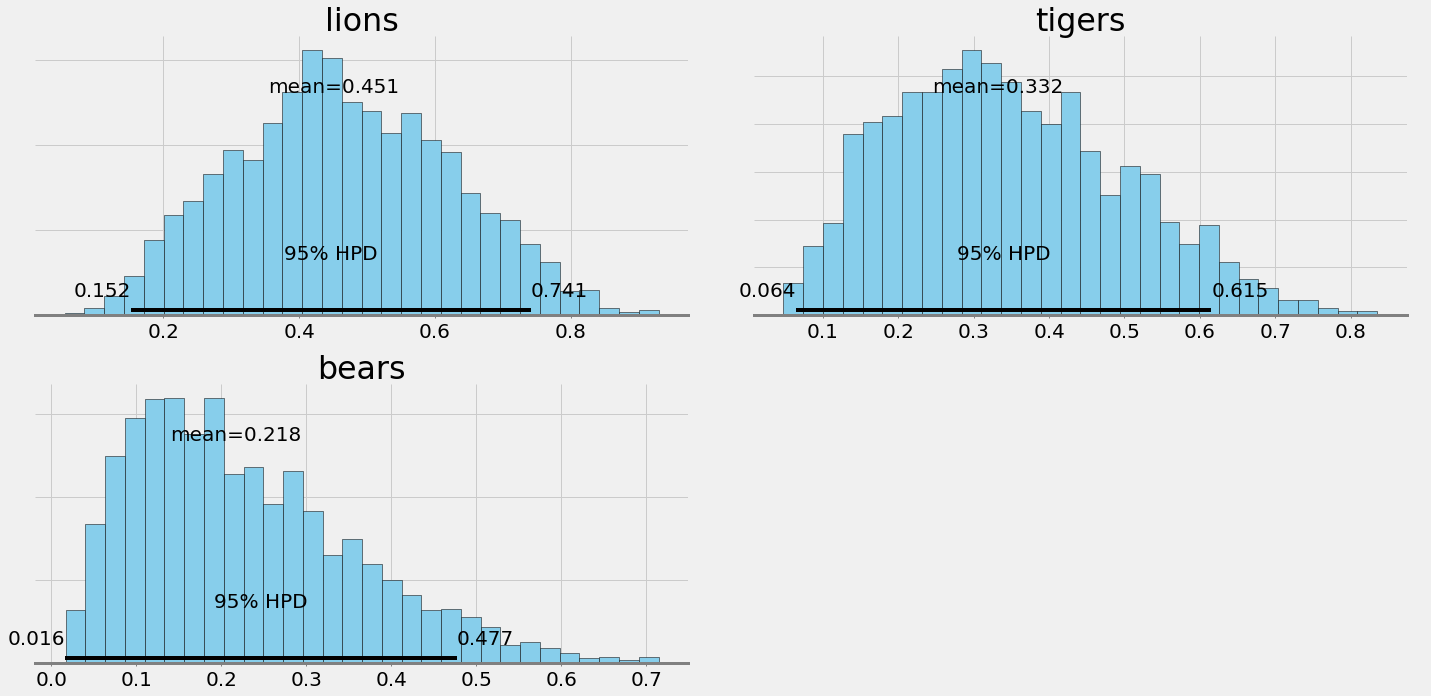

In [20]:
ax = pm.plot_posterior(trace, varnames = ['parameters'], 
                       figsize = (20, 10), edgecolor = 'k');

plt.rcParams['font.size'] = 22
for i, a in enumerate(animals):
    ax[i].set_title(a);

Örneklenen değerlerin histogramlarını gözlemleyebiliyoruz.
%95 HPD demek "Highest Posterior Density" demek.Bu klasik istatistik yöntemlerinde kullanılan %95 lik güven aralığına eş değer.

# Traceplot

traceplot sol tarafta yoğunluk tahminini ve sağ tarafta çekilmiş tüm örnekleri göstermekte.
2 zincirimiz var ama onları birleştirdik.

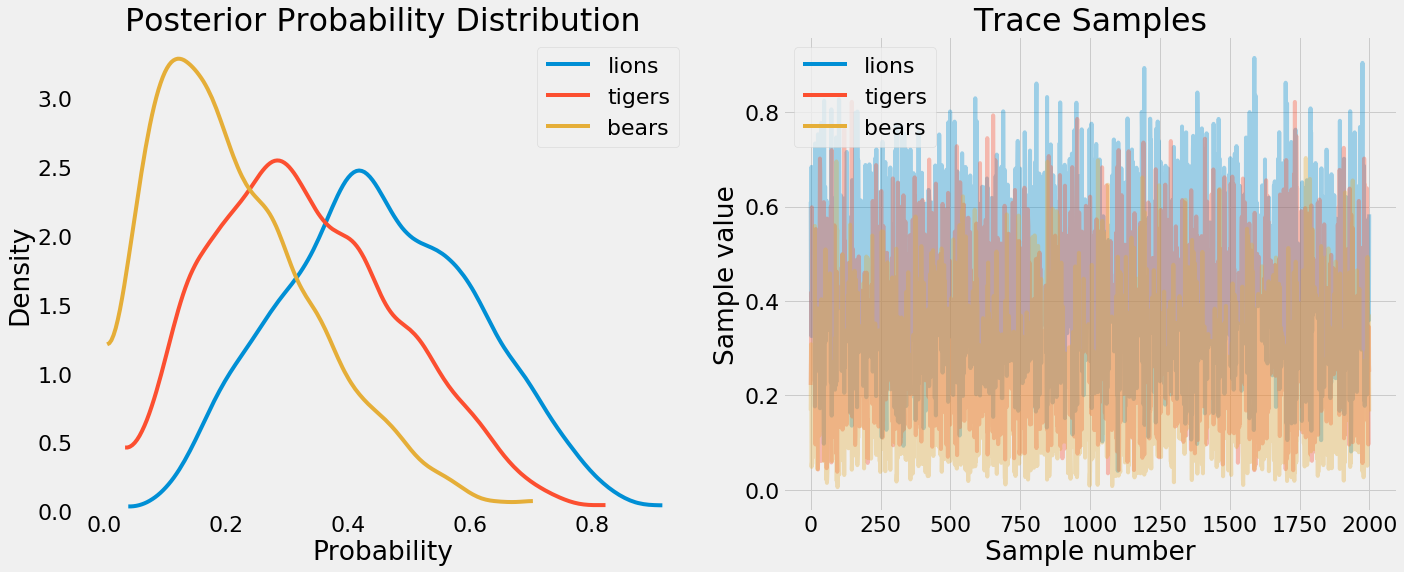

In [21]:
prop_cycle = plt.rcParams['axes.prop_cycle']
cs = [x['color'] for x in list(prop_cycle)]

ax = pm.traceplot(trace, varnames = ['parameters'], figsize = (20, 8), combined = True);
ax[0][0].set_title('Posterior Probability Distribution'); ax[0][1].set_title('Trace Samples');
ax[0][0].set_xlabel('Probability'); ax[0][0].set_ylabel('Density');
ax[0][1].set_xlabel('Sample number');
add_legend(ax[0][0])
add_legend(ax[0][1])

# Maksimum Posterior Result with PyMC3

In [22]:
with model:
    # Find the maximum a posteriori estimate
    map_ = pm.find_MAP()
    
display_probs(dict(zip(animals, map_['parameters'])))

logp = -1.8042, ||grad|| = 1.118: 100%|█████████████████████████████████████████████████| 7/7 [00:00<00:00, 482.71it/s]


Species: lions    Prevalence: 50.00%.
Species: tigers   Prevalence: 33.33%.
Species: bears    Prevalence: 16.67%.


Maksimum Posterior gözlem sayılarıyla aynı oranda tahmin yaptı.Frekansçı yaklaşımı sevenler için güzel bir nokta :)

# Sample From Posterior

Şimdi posterior'u örnekler seçmek için kullanabiliriz.Örneğin 1000 tane safari turuna çıktığımızın simulasyonunu yapalım

In [23]:
with model:
    samples = pm.sample_ppc(trace, samples = 1000)
    
dict(zip(animals, samples['observed_data'].mean(axis = 0)))

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 855.43it/s]


{'lions': 2.774, 'tigers': 1.932, 'bears': 1.294}

Bu sonuç 1000 tane gezi yapsak karşımıza çıkacak hayvan sayısını veriyor

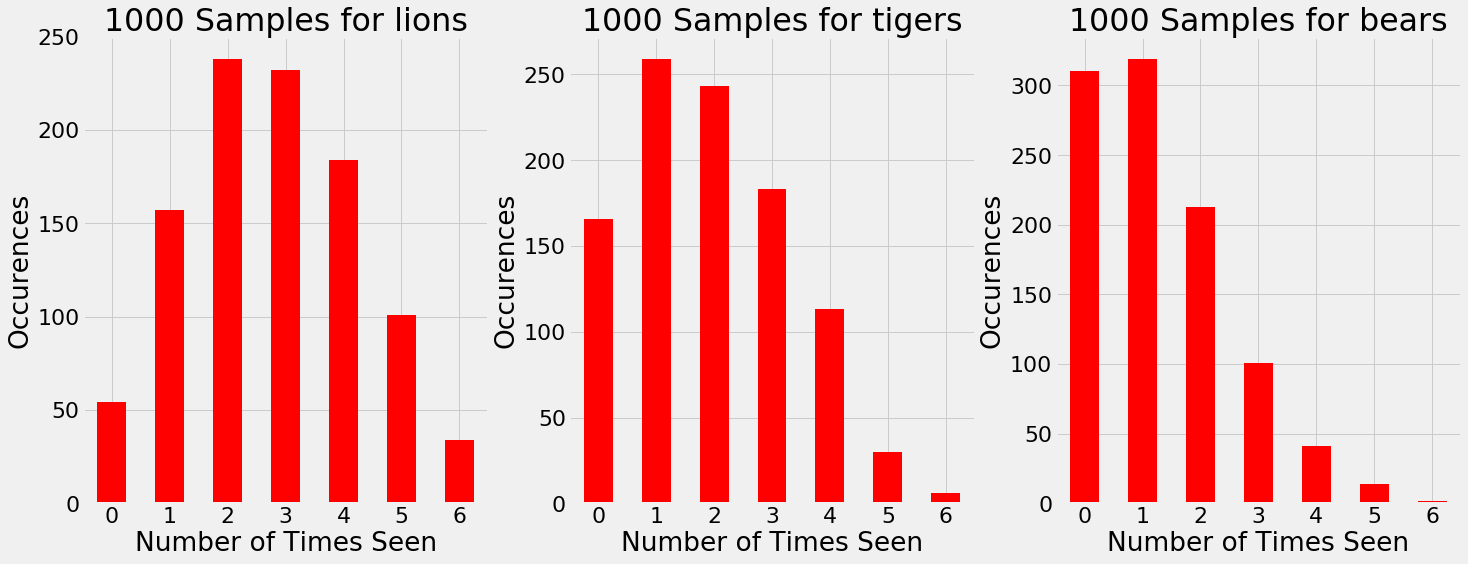

In [24]:
sample_df = pd.DataFrame(samples['observed_data'], columns = animals)

plt.figure(figsize = (22, 8))
for i, animal in enumerate(sample_df):
    plt.subplot(1, 3, i+1)
    sample_df[animal].value_counts().sort_index().plot.bar(color = 'r');
    plt.xticks(range(7), range(7), rotation = 0);
    plt.xlabel('Number of Times Seen'); plt.ylabel('Occurences');
    plt.title(f'1000 Samples for {animal}');

# Dirichlet Dağılımı

Dirichlet Dağılımına ilişkin renkli bir üçgen grafiği çizdirebiliriz.Renkler hiperparametreleri gösteriyor.
Kod şuradan alındı:
    
http://blog.bogatron.net/blog/2014/02/02/visualizing-dirichlet-distributions/

https://gist.github.com/tboggs/8778945


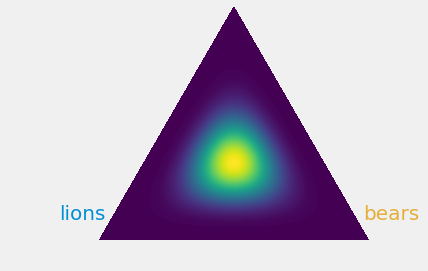

In [25]:
draw_pdf_contours(Dirichlet(6 * alphas))
annotate_plot()

Bu grafik ilk başta her türün eşit olasılıklı olduğunu gösteriyor

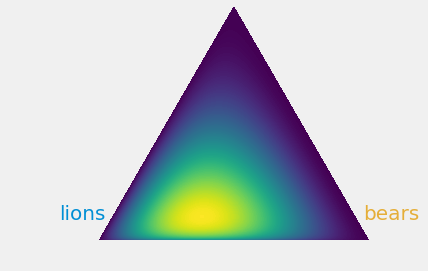

In [26]:
draw_pdf_contours(Dirichlet(6 * pvals))
annotate_plot();

Sampling yaptıktan sonra ağırlık aslanlardan yana kaydı

# Yeni Gözlem

Görmeyi beklediğimiz yeni gözlem için multinomial dağılımdan 10000 kere örnek çekelim.
Her türün görülme olasılığı sampling oranında olacaktır.

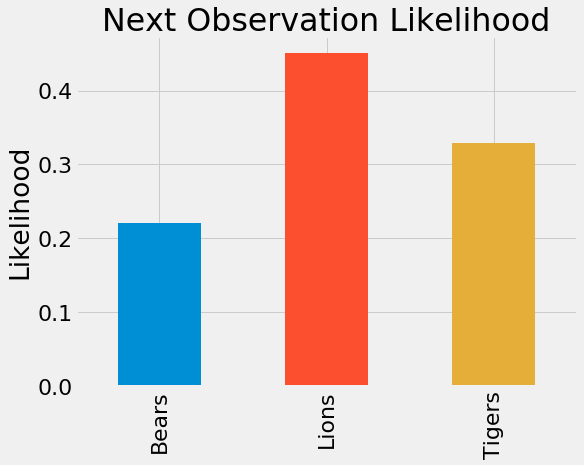

In [27]:
# Draw from the multinomial
next_obs = np.random.multinomial(n = 1, pvals = pvals, size = 10000)

# Data manipulation
next_obs = pd.melt(pd.DataFrame(next_obs, columns = ['Lions', 'Tigers', 'Bears'])).\
            groupby('variable')['value'].\
            value_counts(normalize=True).to_frame().\
             rename(columns = {'value': 'total'}).reset_index()
next_obs = next_obs.loc[next_obs['value'] == 1]

# Bar plot
next_obs.set_index('variable')['total'].plot.bar(figsize = (8, 6));
plt.title('Next Observation Likelihood');
plt.ylabel('Likelihood'); plt.xlabel('');

In [28]:
next_obs.iloc[:, [0, 2]]

,variable,total
1,Bears,0.2207
3,Lions,0.4507
5,Tigers,0.3286


# Daha Fazla Örnek Katalım

Eğer daha fazla gözlemimiz olsaydı ve daha fazla safari yapmış olsaydık direk sampling yapabilirdik

In [29]:
c = np.array([[3, 2, 1],
              [2, 3, 1],
              [3, 2, 1],
              [2, 3, 1]])

with pm.Model() as model:
    # Parameters are a dirichlet distribution
    parameters = pm.Dirichlet('parameters', a=alphas, shape=3)
    # Observed data is a multinomial distribution
    observed_data = pm.Multinomial(
        'observed_data', n=6, p=parameters, shape=3, observed=c)    
    
    trace = pm.sample(draws=1000, chains=2, tune=500, discard_tuned_samples=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [parameters]
Sampling 2 chains: 100%|███████████████████████████████████████████████████████| 3000/3000 [00:10<00:00, 298.49draws/s]


In [30]:
summary = pm.summary(trace)
summary.index = animals
summary

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
lions,0.403626,0.093406,0.002044,0.228883,0.584923,1862.845414,0.999543
tigers,0.411395,0.091988,0.002014,0.245334,0.598688,1907.506575,0.999536
bears,0.184980,0.074981,0.001352,0.053225,0.330453,2104.664223,0.999743


ayılardaki belirsizlik örneklem sayısını arttırınca düştü,aynı zamanda kaplan ile aslan sayıları birbiriyle neredeyse aynı oldu.
Daha çok veriyle daha doğru sonuçlar elde edebiliriz.Çünkü daha büyük data örnekleme de daha az belirsizlik demektir. 

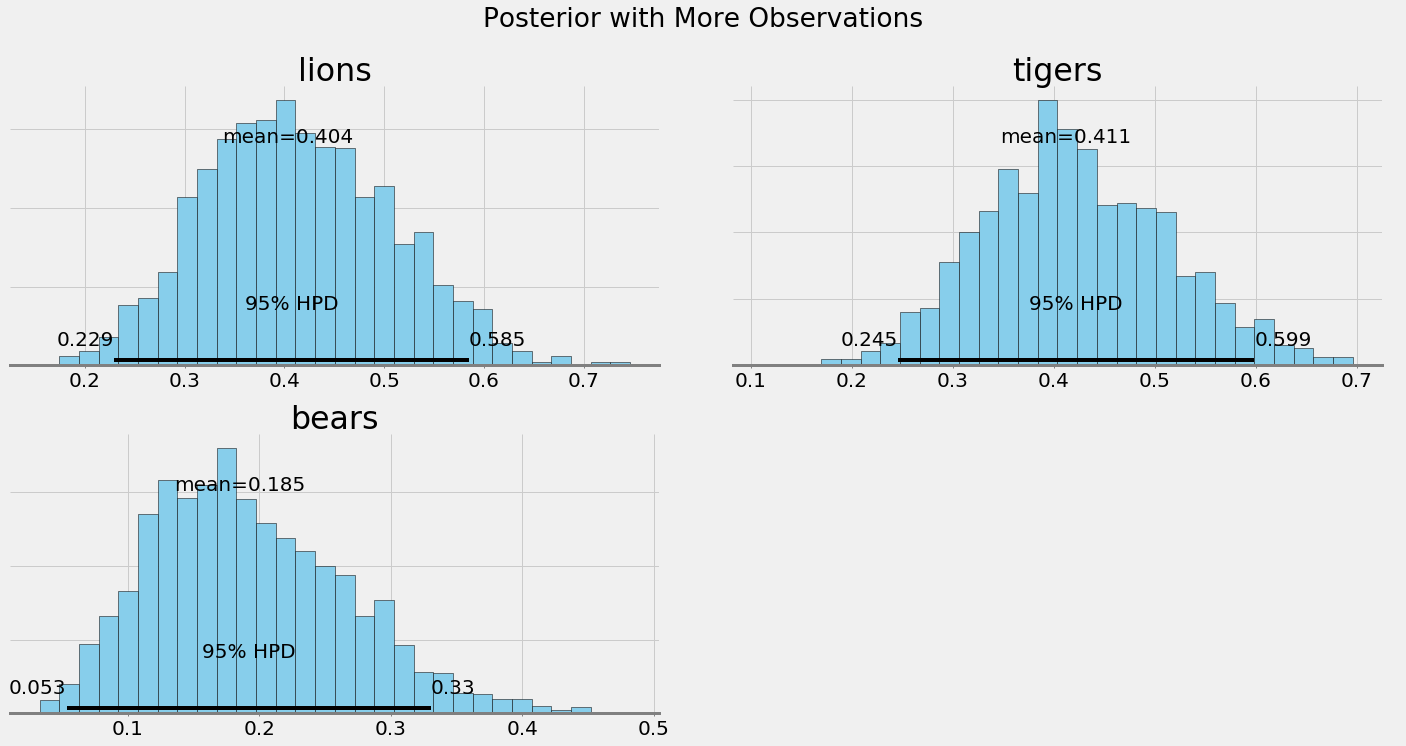

In [31]:
ax = pm.plot_posterior(trace, varnames = ['parameters'], 
                       figsize = (20, 10), edgecolor = 'k');

plt.rcParams['font.size'] = 22
for i, a in enumerate(animals):
    ax[i].set_title(a);
    
plt.suptitle('Posterior with More Observations', y = 1.05);

# Hiperparametre Güven aralığını Arttırıp/Azaltmak

Daha önce belirttiğimiz gibi güven düzeyimizi yani prior düşüncemizi hiperparametrelerle oynayarak değiştirebilirzi.
Ilk olarak tüm türler için parametre olarak 1 kullanmıştık.Bunu arttırıp azaltabiliriz.

In [32]:
# observations
animals = ['lions', 'tigers', 'bears']
c = np.array([3, 2, 1])

def sample_with_priors(alphas):
    """Sample with specified hyperparameters"""
    with pm.Model() as model:
        # Probabilities for each species
        parameters = pm.Dirichlet('parameters', a=alphas, shape=3)
        # Observed data is a multinomial distribution with 6 trials
        observed_data = pm.Multinomial(
            'observed_data', n=6, p=parameters, shape=3, observed=c)    

        trace = pm.sample(draws=1000, chains=2, tune=500, discard_tuned_samples=True)
    return trace

In [33]:
trace_dict = {}
for alpha_array in [np.array([0.1, 0.1, 0.1]), np.array([1, 1, 1]),
                    np.array([5, 5, 5]), np.array([15, 15, 15])]:
    trace_dict[str(alpha_array[0])] = sample_with_priors(alpha_array)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [parameters]
Sampling 2 chains: 100%|███████████████████████████████████████████████████████| 3000/3000 [00:11<00:00, 268.86draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [parameters]
Sampling 2 chains: 100%|███████████████████████████████████████████████████████| 3000/3000 [00:10<00:00, 277.50draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [parameters]
Sampling 2 chains: 100%|███████████████████████████████████████████████████████| 3000/3000 [00:11<00:00, 265.90draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [parameters]
Sampling 2 chains: 100%|███████████████████████████████████████████████████████| 3000/30

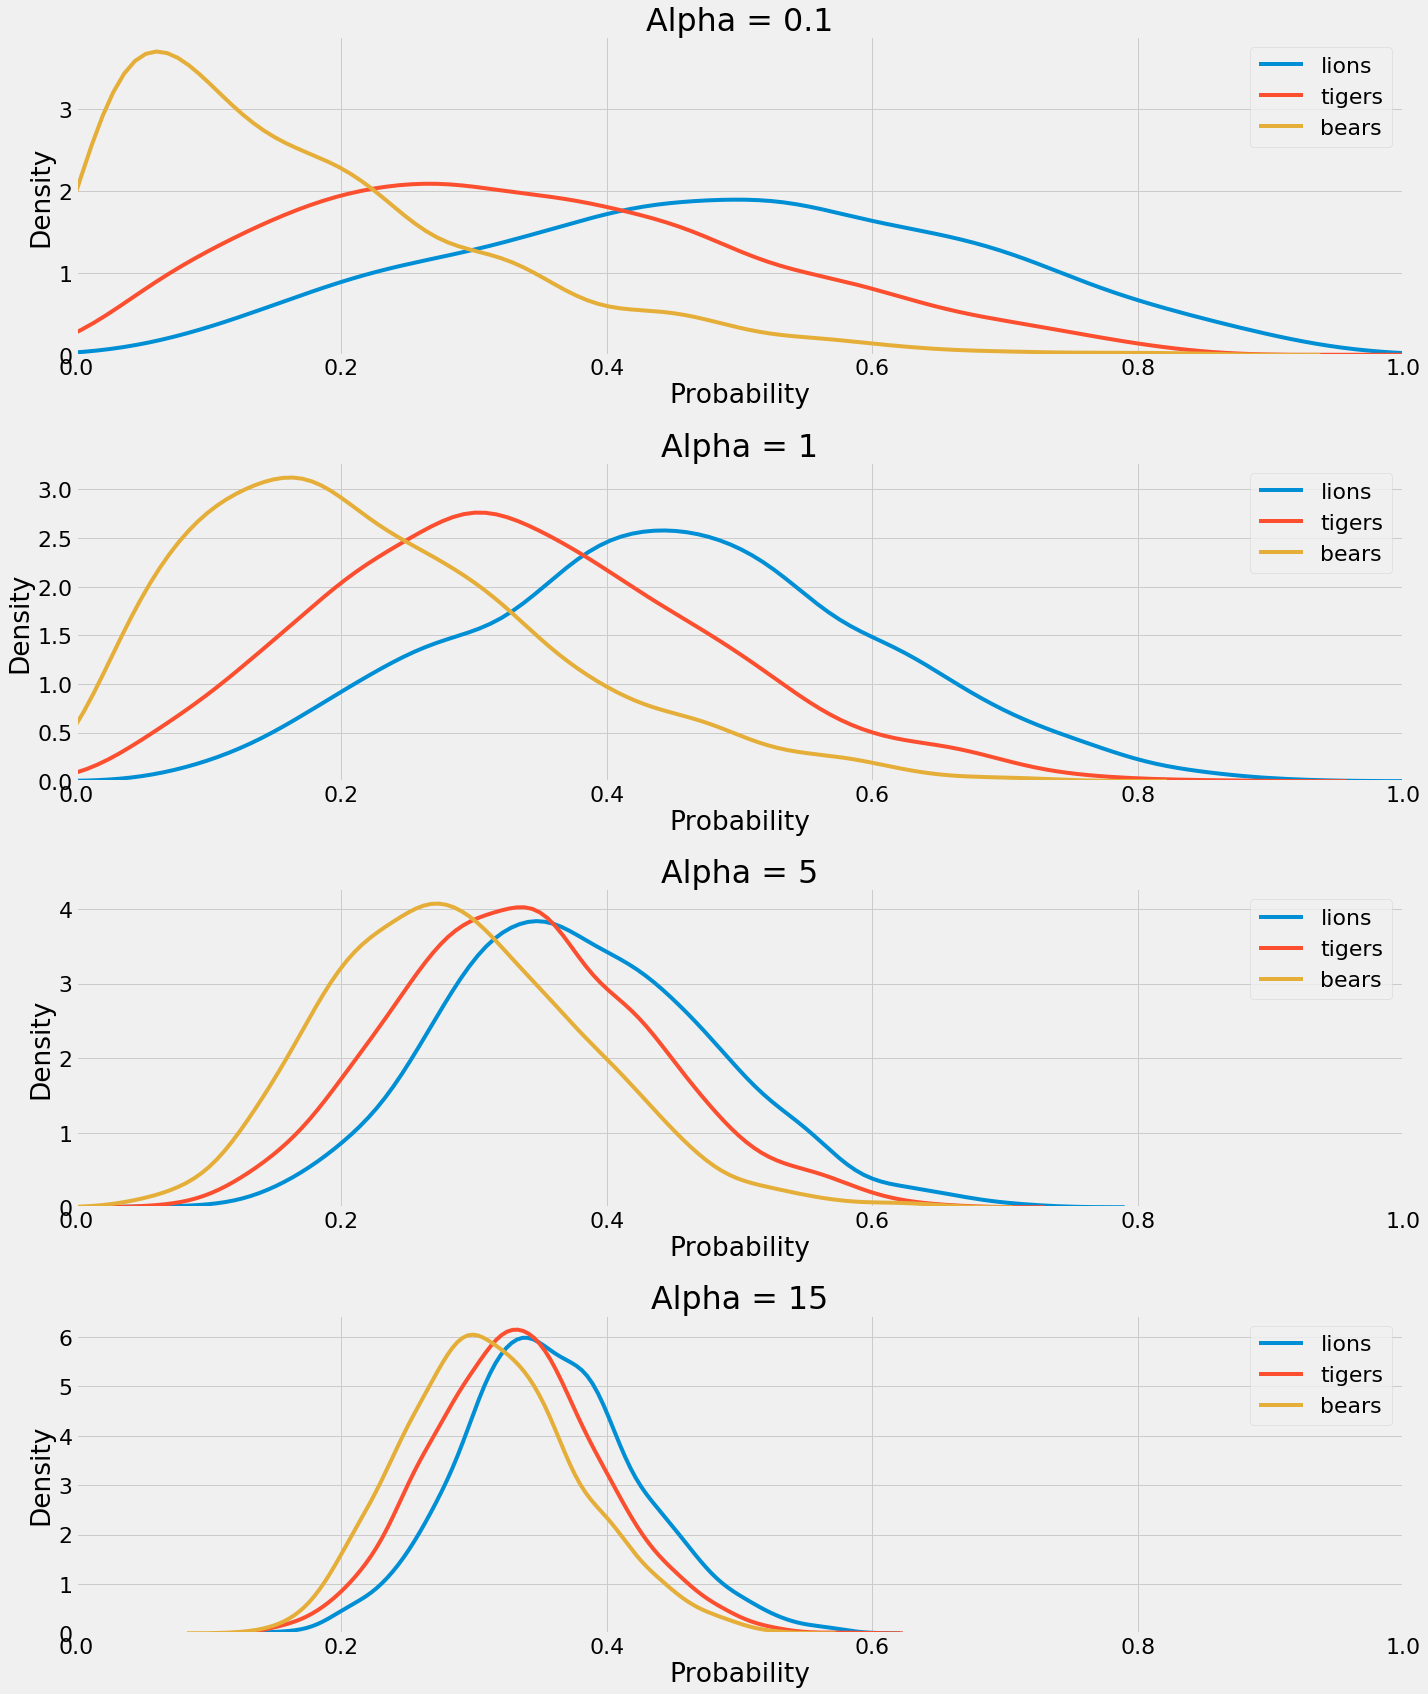

In [34]:
plt.figure(figsize = (20, 24))

for ii, (alpha, trace) in enumerate(trace_dict.items()):
    plt.subplot(4, 1, ii + 1)
    array = trace['parameters']
    for jj, animal in enumerate(animals):
        sns.kdeplot(array[:, jj], label = f'{animal}')
    plt.legend();
    plt.xlabel('Probability'); plt.ylabel('Density')
    plt.title(f'Alpha = {alpha}');
    plt.xlim((0, 1));
    
plt.tight_layout();
plt.show();

hiperparametre ağırlıkları arttıkça tahminler 1/3 civarında toplanıyor.
Bu sonuçlar aslında sezgiseldir aynı zamanda.
Çünkü eğer gerçekten tüm türlerden görülme olasılığının eşit olduğuna inanıyorsak,topladığımız sınırlı sayıda data bizim prior 
düşüncelerimizi değiştirmemeliydi.

# Prior Düşüncelerimizin Karşılaştırılması

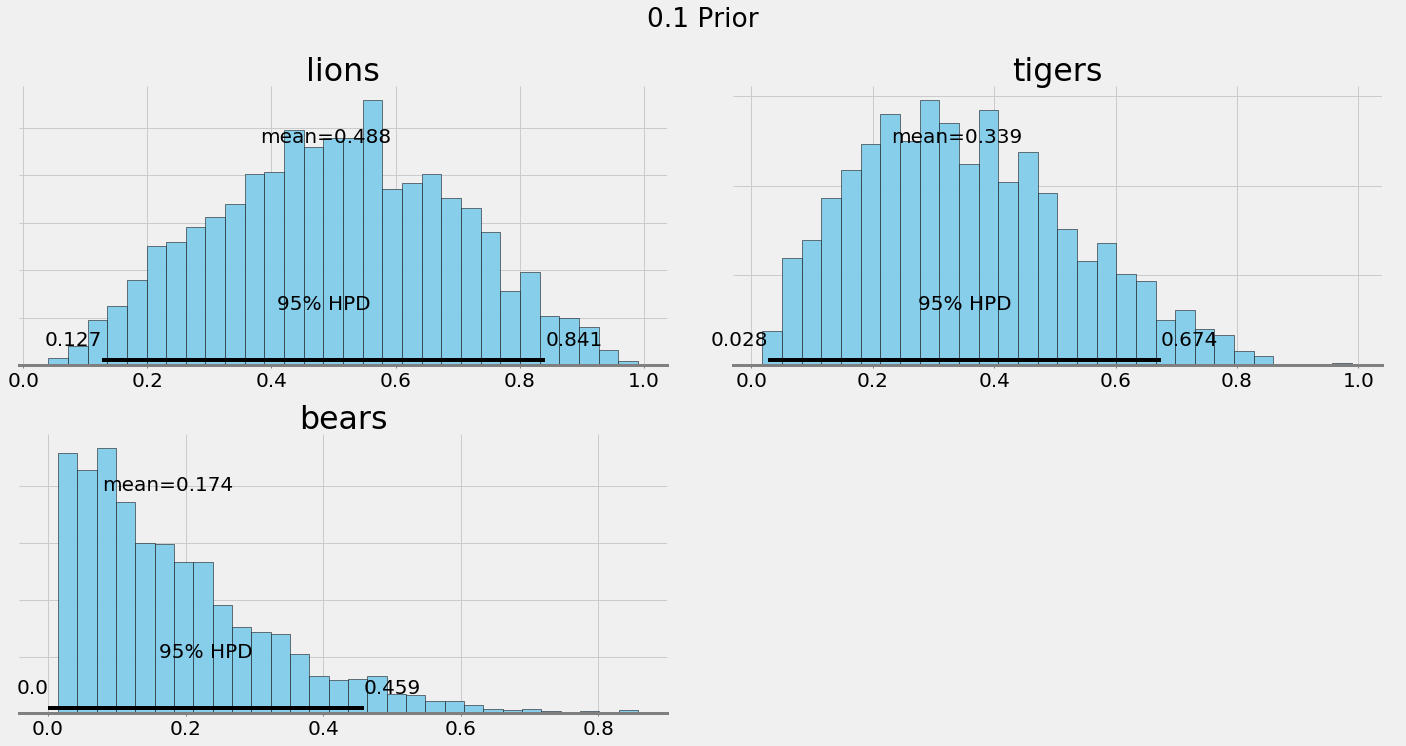

In [35]:
prior = '0.1'
trace = trace_dict[prior]

ax = pm.plot_posterior(trace, varnames = ['parameters'], 
                       figsize = (20, 10), edgecolor = 'k');

plt.rcParams['font.size'] = 22
for i, a in enumerate(animals):
    ax[i].set_title(a);
    
plt.suptitle(f'{prior} Prior', y = 1.05);

In [36]:
summary = pm.summary(trace)
summary.index = animals
summary

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
lions,0.487734,0.190652,0.003941,0.126874,0.841341,2032.438651,1.000885
tigers,0.338658,0.176574,0.003340,0.027903,0.674215,2081.280652,0.999875
bears,0.173608,0.143083,0.003421,0.000252,0.458807,1851.331878,1.000159


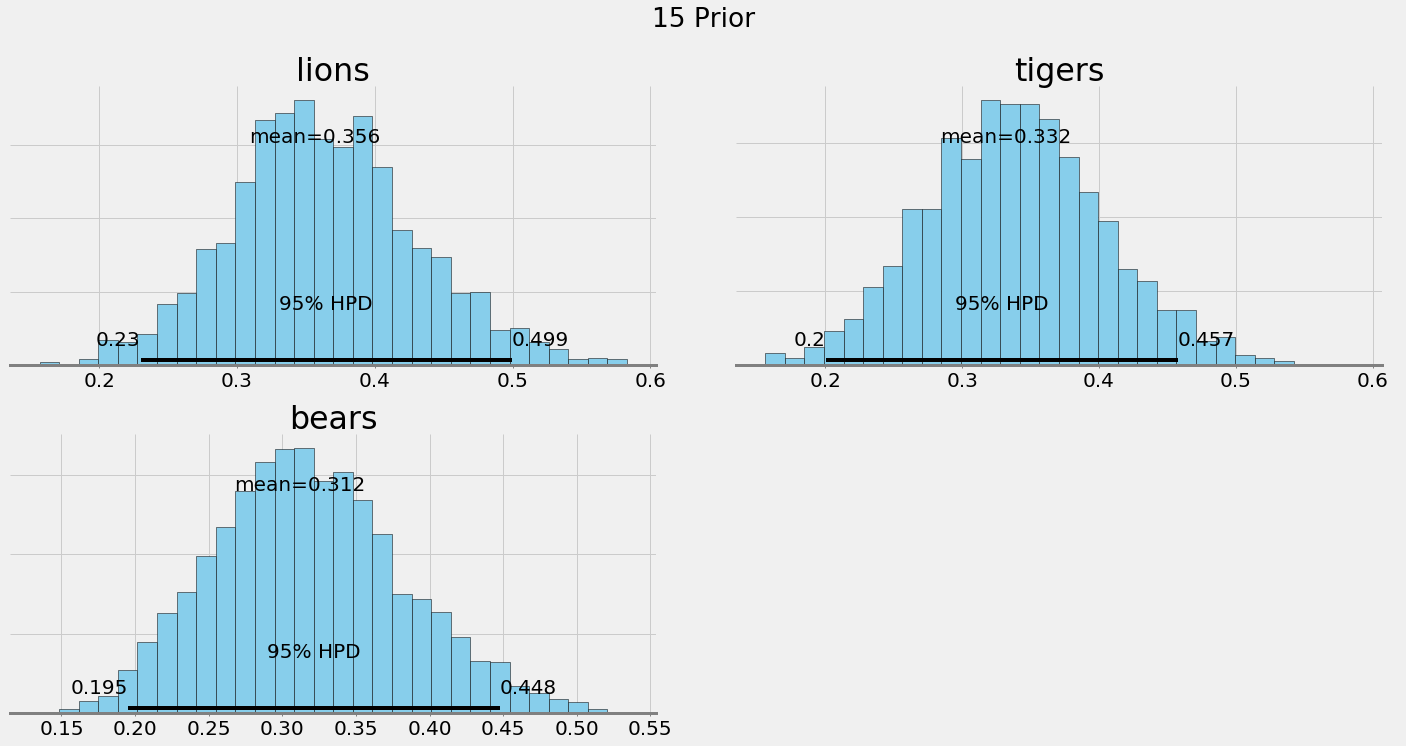

In [37]:
prior = '15'
trace = trace_dict[prior]

ax = pm.plot_posterior(trace, varnames = ['parameters'], 
                       figsize = (20, 10), edgecolor = 'k');

plt.rcParams['font.size'] = 22
for i, a in enumerate(animals):
    ax[i].set_title(a);
    
plt.suptitle(f'{prior} Prior', y = 1.05);

In [38]:
summary = pm.summary(trace)
summary.index = animals
summary

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
lions,0.356384,0.067282,0.001379,0.229980,0.499322,2086.978216,0.999733
tigers,0.331595,0.065321,0.001274,0.200476,0.457444,2054.186250,0.999996
bears,0.312021,0.065148,0.001316,0.195266,0.447809,2159.717391,0.999543


Özetle,hyper prior seçimi tamamen bizim ilk ön yargısal düşüncemize kalıyor diyebiliriz.
Prior'un 15 olduğu son grafikten de anlayabileceğimiz gibi eğer gerçekten tüm hayvanların görülme olasılığının eşit olduğunu
düşünüyorsak o zaman prior ağırlıklarımızı arttırmalıyız

# SONUÇLAR

In [39]:
prior = '1'
trace = trace_dict[prior]
summary = pm.summary(trace)
summary.index = animals
summary

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
lions,0.445579,0.152822,0.003076,0.160435,0.748734,2084.162566,0.999500
tigers,0.331878,0.143625,0.003253,0.059293,0.610314,2037.799348,0.999537
bears,0.222543,0.132671,0.002723,0.021075,0.489113,1993.960153,0.999552


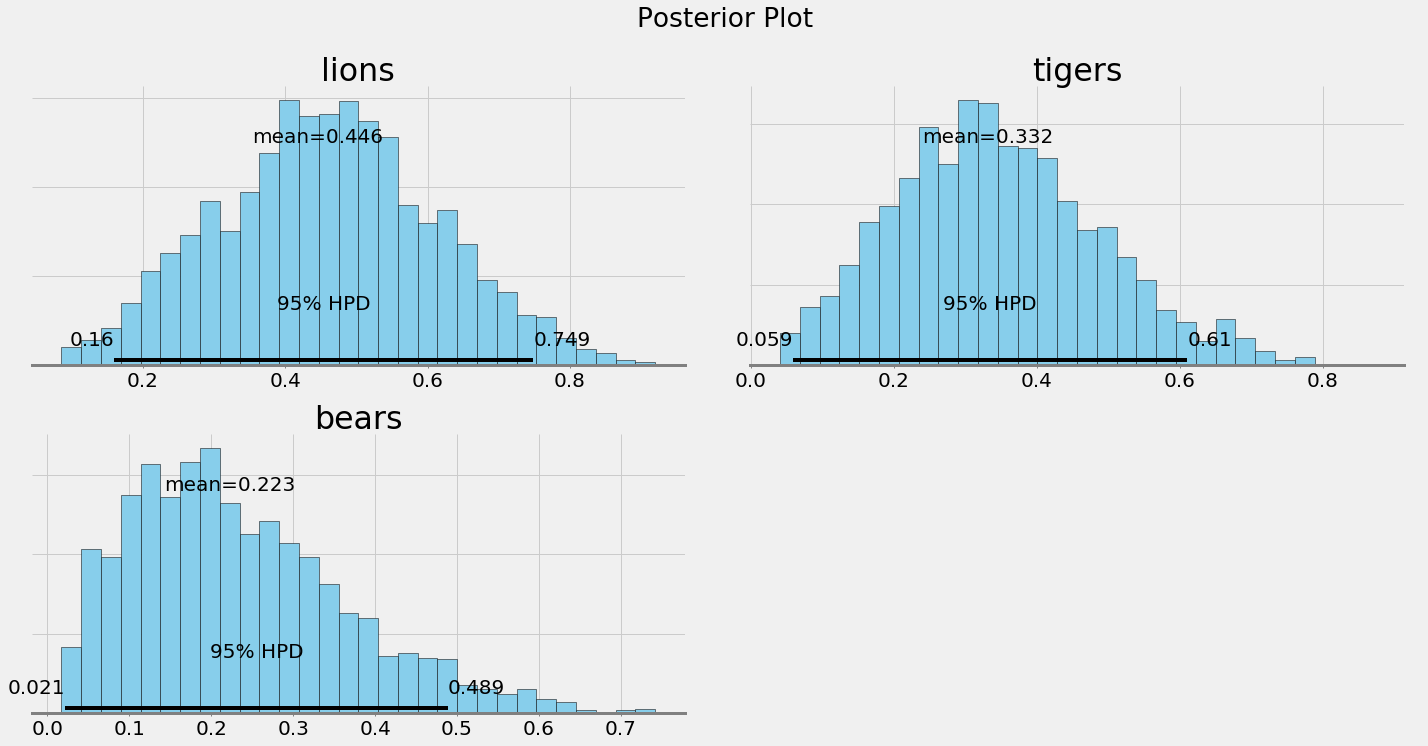

In [40]:
ax = pm.plot_posterior(trace, varnames = ['parameters'], 
                       figsize = (20, 10), edgecolor = 'k');

plt.rcParams['font.size'] = 22
for i, a in enumerate(animals):
    ax[i].set_title(a);
    
plt.suptitle('Posterior Plot', y = 1.05);

En başta sorulan soruya ilişkin şu yanıtları verebiliriz :
    
%95 HPD ile türlerin tahmini ortalama görülme olasılıkları:

-Lions: 44.5% (16.9% - 75.8%)
    
-Tigers: 32.7% (6.7% - 60.5%)
    
-Bears: 22.7% (1.7% - 50.0%)
    

# Gözlenecek yeni türün Ayı olma olasılığı

Sampling'e göre bu olasılık %22.9'dur.

Bayesçi çıkarsamanın en iyi yönü prior ve belirsizliklerin kolkola gezip bunlara ilişkin sonuç bulmak için bazı methodları 
birleştirmektir.

Daha önce söylediğimiz gibi daha fazla gözlem daha doğru sonuçlar !

Teşekkürler

Kaynak : https://towardsdatascience.com/estimating-probabilities-with-bayesian-modeling-in-python-7144be007815